In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
oxy_sub1=scipy.io.loadmat('fMRIdata/subject1.mat')
oxy_sub1

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Dec 17 12:41:17 2018',
 '__version__': '1.0',
 '__globals__': [],
 'mts': array([[[ 0.53178191, -0.74142832,  0.08471838, ..., -0.19812649,
           1.39021933,  2.84606743]],
 
        [[ 0.11361951,  2.29740763, -2.17058587, ..., -5.01498079,
          -5.85067225, -7.73369217]],
 
        [[-0.59797937,  2.14257908, -1.17834437, ...,  2.36086655,
           1.63610208,  1.81495059]],
 
        [[-0.99375767,  1.94832361,  0.30337405, ..., -0.58349335,
          -0.08255861,  0.64588344]]]),
 'roi_name': array([['LLP.nii '],
        ['mPFC.nii'],
        ['PCC.nii '],
        ['RLP.nii ']], dtype='<U8'),
 'roi_size': array([[1041],
        [1346],
        [4833],
        [1326]])}

In [3]:
llp = oxy_sub1['mts'][0][0]
mpfc = oxy_sub1['mts'][1][0]
pcc = oxy_sub1['mts'][2][0]
rlp = oxy_sub1['mts'][3][0]

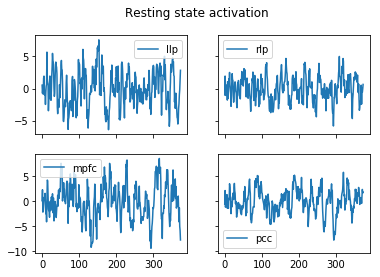

In [4]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('Resting state activation')
ax1.plot(llp, label="llp")
ax1.legend()
ax2.plot(rlp,label = "rlp")
ax2.legend()
ax3.plot(mpfc,label = "mpfc")
ax3.legend()
ax4.plot(pcc,label = "pcc")
ax4.legend()

In [11]:
def covarient(sigma, rho):
    C = th.alloc(rho, 2, 2)
    C = th.fill_diagonal(C, 1.)
    S = th.diag(sigma)
    return S.dot(C).dot(S)

def Bayesian_Pearson(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., tau=0.000001, shape=2, testval=np.mean(data, axis=1))
        sigma = pm.Uniform('sigma', lower=1e-6, upper=1000., shape=2, testval=np.std(data, axis=1))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0)

        cov = pm.Deterministic('tau', covarient(sigma, rho))
        mult_n = pm.MvNormal('mult_n', mu=mu, cov=cov, observed=data.T)

    return model

In [6]:
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc,pcc))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc,rlp))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc,llp))
print("Pearson PCC:RLP",sp.stats.pearsonr(pcc,rlp))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc,llp))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp,llp))

Pearson MPFC:PCC (0.39336180539734866, 2.7307105982803503e-15)
Pearson MPFC:RLP (0.5200380786307496, 2.6708893667974765e-27)
Pearson MPFC:LLP (0.04532479678321221, 0.3820883045670219)
Pearson PCC:RLP (0.3829440623285536, 1.6472109726087946e-14)
Pearson PCC:LLP (0.3010158776281227, 2.8464702726289563e-09)
Pearson RLP:LLP (0.5473668527719466, 1.2840988588268106e-30)


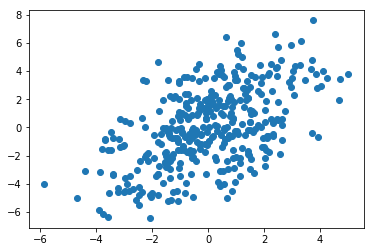

In [7]:
rlp_llp = np.array([rlp,llp])
plt.scatter(rlp,llp)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hstrey/miniconda3/envs/pymc3class/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, sigma, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:22<00:00, 254.06draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c276929e8>,
      dtype=object)

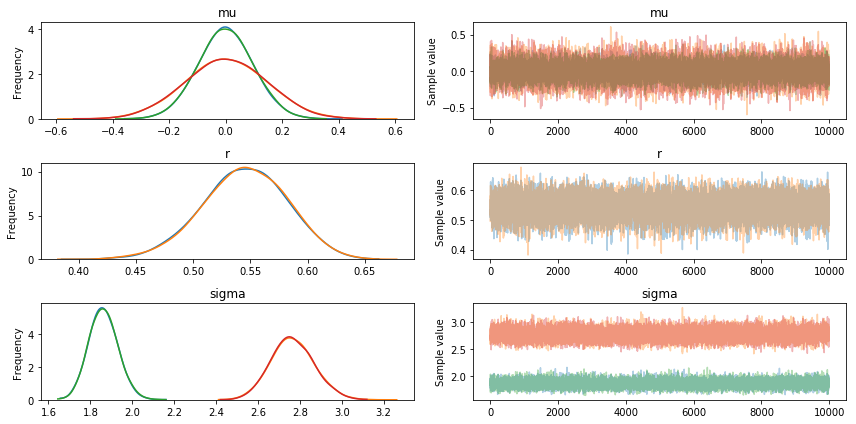

In [12]:
model = Bayesian_Pearson(rlp_llp)
with model:
    trace = pm.sample(10000)
pm.traceplot(trace, varnames=['mu', 'r', 'sigma'])

In [13]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,0.00,0.10,0.0,-0.19,0.19,16581.46,1.0
mu__1,0.00,0.14,0.0,-0.29,0.27,15897.79,1.0
sigma__0,1.86,0.07,0.0,1.73,2.00,15840.07,1.0
sigma__1,2.77,0.10,0.0,2.57,2.97,15173.93,1.0
r,0.54,0.04,0.0,0.47,0.61,14750.69,1.0
tau__0_0,3.48,0.26,0.0,2.99,3.99,15759.18,1.0
tau__0_1,2.81,0.31,0.0,2.22,3.42,11929.76,1.0
tau__1_0,2.81,0.31,0.0,2.22,3.42,11929.76,1.0
tau__1_1,7.66,0.56,0.0,6.60,8.80,15150.96,1.0
